In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rajesh@7756',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Rajesh/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Rajesh@7756",
                            database = "ecommerce")

cur = db. cursor()

## List all unique cities where customers are located.

In [4]:
query = """ select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [5]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders places in 2017 are", data[0][0]

('total orders places in 2017 are', 135303)

# Find the total sales per category.

In [6]:
query = """ select upper(products.product_category) category, sum(payments.payment_value) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,6.080864e+06
1,FURNITURE DECORATION,1.716212e+07
2,TELEPHONY,5.842585e+06
3,FASHION BAGS AND ACCESSORIES,2.617899e+06
4,BED TABLE BATH,2.055064e+07
...,...,...
69,CDS MUSIC DVDS,1.439316e+04
70,LA CUISINE,3.496236e+04
71,FASHION CHILDREN'S CLOTHING,9.428040e+03
72,PC GAMER,2.609316e+04


# Calculate the percentage of orders that were paid in installments.

In [7]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()

data
"the percentage of orders that were paid in installments is ", data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state. 

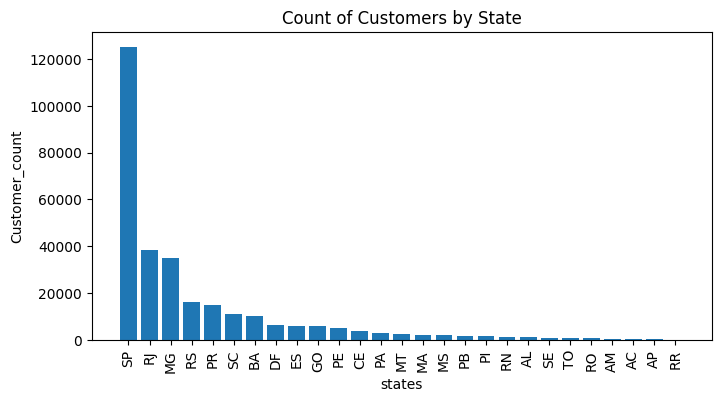

In [8]:
query = """ select customer_state, count(customer_id) from customers group by customer_state """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["State","Customer_count"])
df = df.sort_values(by = "Customer_count", ascending = False)

plt.figure(figsize = (8,4))
plt.bar(df["State"], df["Customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("Customer_count")
plt.title("Count of Customers by State")
plt.show()

# Calculate the number of orders per month in 2018.

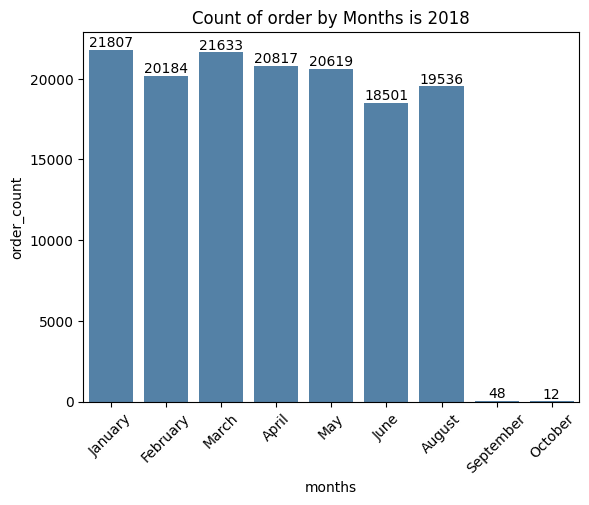

In [9]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "May","June","August","September","October"]

ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o, color = "steelblue")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of order by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [10]:
query = """ with count_per_order as 
        (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
        from orders join order_items
        on orders.order_id = order_items.order_id
        group by orders.order_id, orders.customer_id)
        
    select customers.customer_city, round(avg(count_per_order.oc),2) as average_orders
    from customers join count_per_order
    on customers.customer_id = count_per_order.customer_id
    group by customers.customer_city order by average_orders desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_city", "average products per orders"])
df.head(10)

,customer_city,average products per orders
0,padre carvalho,42.00
1,celso ramos,39.00
2,datas,36.00
3,candido godoi,36.00
4,matias olimpio,30.00
5,cidelandia,24.00
6,curralinho,24.00
7,picarra,24.00
8,morro de sao paulo,24.00
9,teixeira soares,24.00


# Calculate the percentage of total revenue contributed by each product category.

In [11]:
query = """ select upper(products.product_category) category, 
            round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
            from products join order_items
            on products.product_id = order_items.product_id
            join payments
            on payments.order_id = order_items.order_id
            group by category order by sales_percentage desc """

cur.execute(query)

data = cur.fetchall() 
df = pd.DataFrame(data, columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,64.19
1,HEALTH BEAUTY,62.12
2,COMPUTER ACCESSORIES,59.42
3,FURNITURE DECORATION,53.60
4,WATCHES PRESENT,53.57


# Identify the correlation between product price and the number of times a product has been purchased.

In [12]:
import numpy as np

query = """ select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""

cur.execute(query)

data = cur.fetchall() 
df = pd.DataFrame(data, columns = ["Category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1, arr2])
print('the correlation betwee price and number of times a product has been purchesd is', a[0][1])

the correlation betwee price and number of times a product has been purchesd is -0.10631514167157569


# Calculate the total revenue generated by each seller, and rank them by revenue.

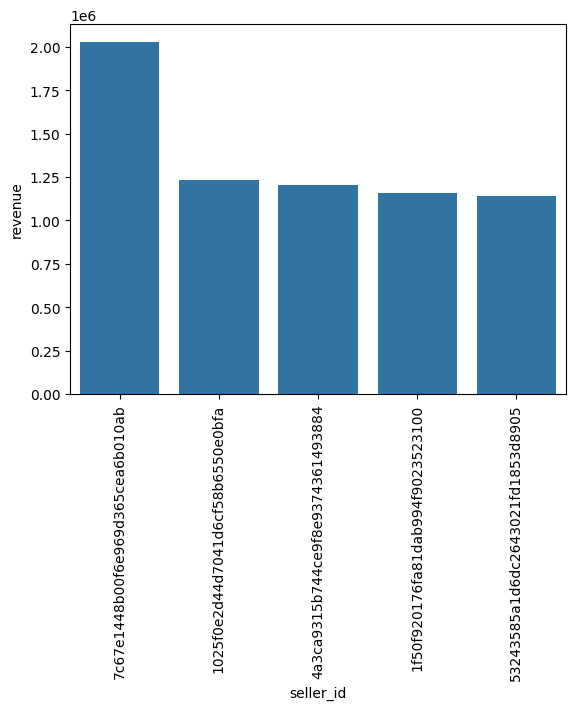

In [13]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)

data = cur.fetchall() 
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head(5)
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [14]:
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg
from 
    (select orders.customer_id, orders.order_purchase_timestamp,
    payments.payment_value as payment
    from payments join orders
    on payments.order_id = orders.order_id) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id","timestamp","price", "moving_avg"])
df.head(10)

,customer_id,timestamp,price,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
5,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
6,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
7,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
8,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
9,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004


# Calculate the cumulative sales per month for each year.

In [15]:
query = """ select years, months, payment, sum(payment) over(order by years, months) cumulative_sales
from
    (select year(orders.order_purchase_timestamp) as years,
    month(orders.order_purchase_timestamp) as months,
    round(sum(payments.payment_value),2) as payment from orders join payments
    on orders.order_id = payments.order_id
    group by years,months
    order by years, months) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","months","payment", "cumulative_sales"])
df.head(10)

,years,months,payment,cumulative_sales
0,2016,9,1513.44,1513.44
1,2016,10,354542.88,356056.32
2,2016,12,117.72,356174.04
3,2017,1,830928.24,1187102.28
4,2017,2,1751448.06,2938550.34
5,2017,3,2699181.60,5637731.94
6,2017,4,2506728.18,8144460.12
7,2017,5,3557512.92,11701973.04
8,2017,6,3067658.28,14769631.32
9,2017,7,3554297.52,18323928.84


#  Calculate the year-over-year growth rate of total sales.

In [16]:
query = """ with a as (select year(orders.order_purchase_timestamp) as years,
    round(sum(payments.payment_value),2) as payment from orders join payments
    on orders.order_id = payments.order_id
    group by years
    order by years)
    
    select years, ((payment - lag(payment, 1) over(order by years))/
    lag(payment, 1) over(order by years)) * 100 privious_year from a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % frowth"])
df

,years,yoy % frowth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [17]:
query = """with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""

cur.execute(query)

data = cur.fetchall()
data

[(None,)]

## Identify the top 3 customers who spent the most money in each year.

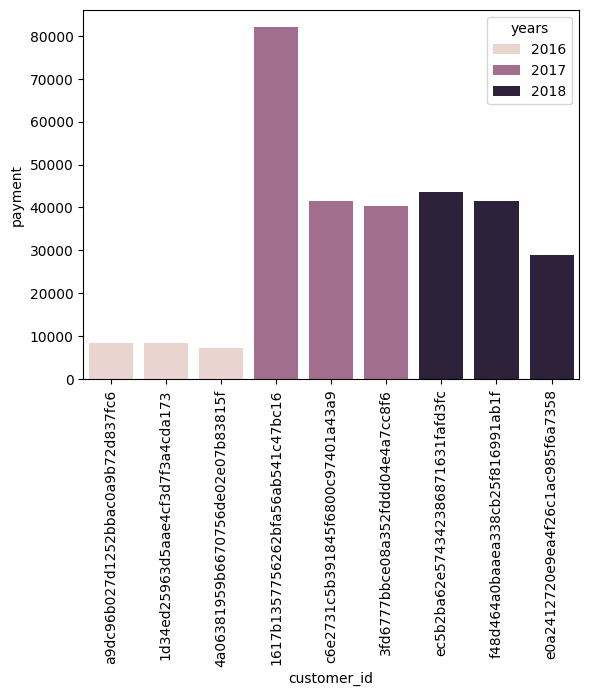

In [18]:
query = """ select years, customer_id, payment, d_rank
from
    (select year(orders.order_purchase_timestamp) years, orders.customer_id, sum(payments.payment_value) payment,
    dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
    from orders join payments
    on payments.order_id = orders.order_id
    group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank <= 3"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "customer_id","payment", "rank"])
sns.barplot(x = "customer_id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()